# Mask R-CNN - Inspect Ofstar Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL.Image as Image

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import ofstar

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
OFSTAR_WEIGHTS_PATH = "./mask_rcnn_ofstar_0019.h5"  # TODO: update this path

C:\Users\ama49\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
config = ofstar.OfstarConfig()
OFSTAR_DIR = os.path.join(ROOT_DIR, "dataset/")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = ofstar.OfstarDataset()
dataset.load_ofstar(OFSTAR_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 10
Classes: ['BG', 'O', 'F', 'Star']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [8]:
# Set path to ofstar weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = OFSTAR_WEIGHTS_PATH

# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ./mask_rcnn_ofstar_0019.h5


## Run Detection

Original image shape:  [492 692   3]
image ID: ofstar.004844.jpg (5) C:\Amr\NexGem\Code\dataset/val\004844.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (4,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (4, 4)                min:  118.00000  max: 1015.00000  int32
gt_mask                  shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  bool


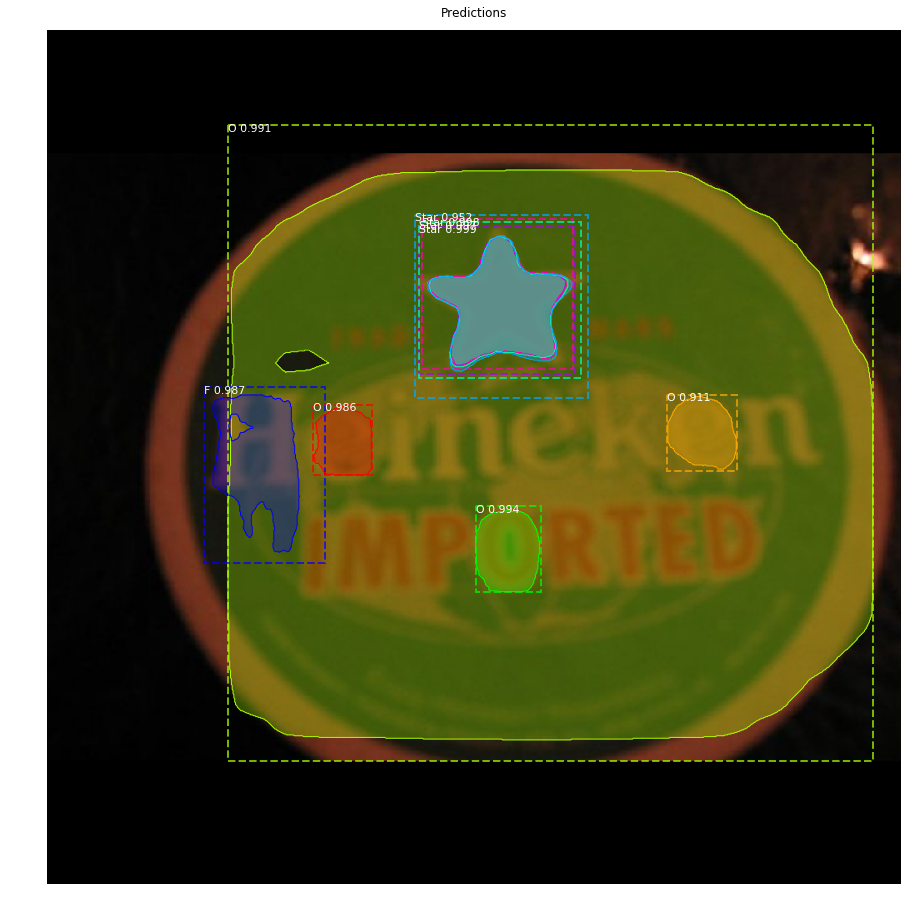

In [9]:
image_id = dataset.image_ids[5]  #choose image id or make it random
#image_id = random.choice(dataset.image_ids)
#image = dataset.load_image(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


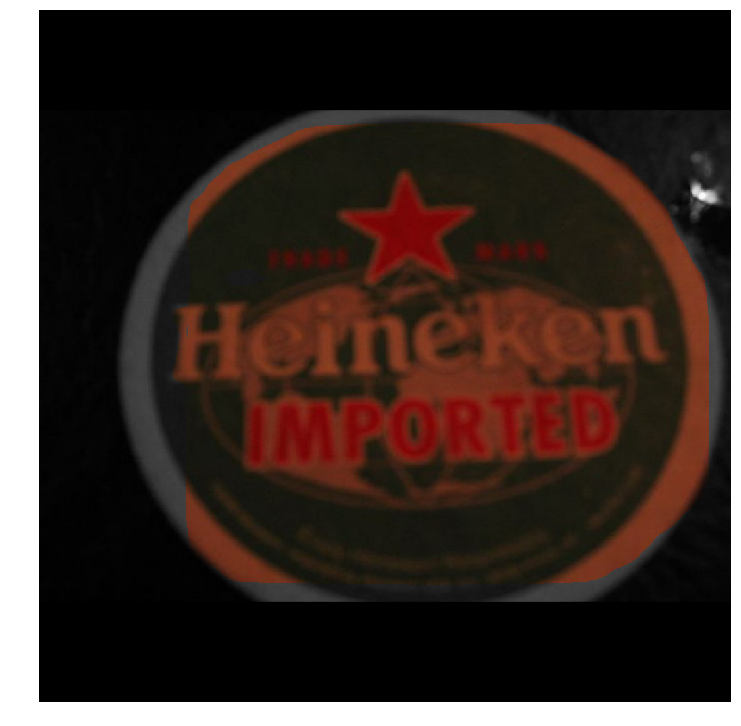

In [10]:
splash = ofstar.color_splash(image, r['masks'])
display_images([splash], cols=1)

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 4, 4)       min:   -4.07081  max:    4.13002  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    3.00000  float32
6 detections: ['Star' 'F' 'O' 'O' 'O' 'O']


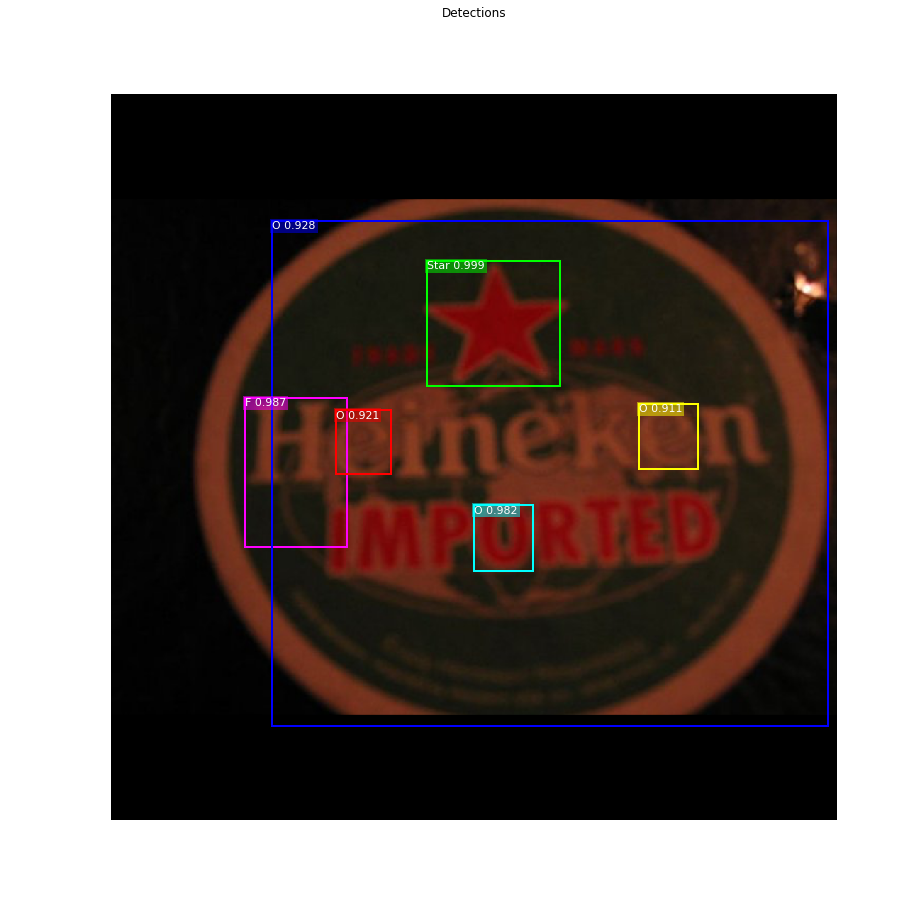

In [12]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

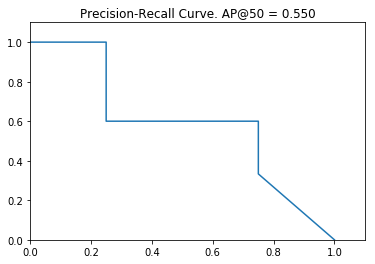

In [13]:
#The PR curve is for SINGLE detected image
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

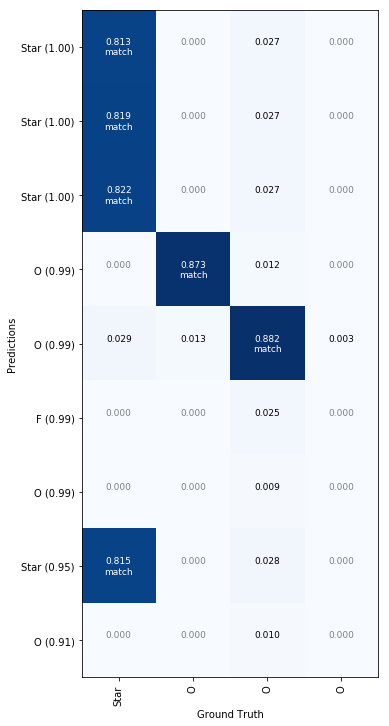

In [14]:
# Grid of ground truth objects and their predictions for SINGLE IMAGE
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

In [15]:
"""Compute AP over a range or IoU thresholds. Default range is 0.5-0.95."""
mAP=utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])

AP @0.50:	 0.550
AP @0.55:	 0.550
AP @0.60:	 0.550
AP @0.65:	 0.550
AP @0.70:	 0.550
AP @0.75:	 0.550
AP @0.80:	 0.550
AP @0.85:	 0.200
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.405


In [16]:
"""Compute the recall at the given IoU threshold. It's an indication
    of how many GT boxes were found by the given prediction boxes.

    pred_boxes: [N, (y1, x1, y2, x2)] in image coordinates
    gt_boxes: [N, (y1, x1, y2, x2)] in image coordinates
    """
recall, positive_ids = utils.compute_recall(r['rois'], gt_bbox, 0.5)

In [17]:
print(recall)
print(positive_ids)

0.75
[0 1 2 3 4 7]


In [ ]:
# Compute VOC-style Average Precision
# better to run on gpu. for cpu, kernel sometimes die.
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 10)
image_ids = dataset.image_ids
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

In [ ]:
# better to run on gpu. for cpu, kernel sometimes die.
def compute_batch_recall(image_ids):
    o_gt, f_gt, star_gt, o_pred, f_pred, star_pred, o_TP, f_TP, star_TP = [], [], [], [], [], [], [], [], []
    positive_ids = []
    gt_bboxes =[]
    pred_bboxes = []
    FPs = []
    FNs = []
    
    for i, image_id in enumerate(image_ids):
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        info = dataset.image_info[image_id]
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        recall, positive_id = utils.compute_recall(r['rois'], gt_bbox, 0.5)
        
        
        o_gt.append(list(gt_class_id).count(1)); f_gt.append(list(gt_class_id).count(2)); star_gt.append(list(gt_class_id).count(3))
        o_pred.append(list(r['class_ids']).count(1)); f_pred.append(list(r['class_ids']).count(2)); star_pred.append(list(r['class_ids']).count(3))
        o_TP.append([list(r['class_ids'])[i] for i in list(positive_id)].count(1))
        f_TP.append([list(r['class_ids'])[i] for i in list(positive_id)].count(2))
        star_TP.append([list(r['class_ids'])[i] for i in list(positive_id)].count(3))
        
        FP = len(r['rois'])- len(positive_id)
        FN = len(gt_bbox)  - len(positive_id)
        precision =0 if  len(positive_id)==0 else len(positive_id) / len(r['rois'])
        
        print('image_id: {}, ground truth:{}, predictions: {}, TP: {}, FP:{}, FN:{}, recall:{}, precision:{}'.format(i,len(gt_bbox), len(r['rois']),len(positive_id),FP ,FN ,np.round(recall,4) ,np.round(precision,4)))
        
    return [sum(o_gt), sum(f_gt), sum(star_gt), sum(o_pred), sum(f_pred), sum(star_pred), sum(o_TP), sum(f_TP), sum(star_TP)]
  
details = compute_batch_recall(dataset.image_ids)
print('gts:{} [O:{}, F:{}, Star:{}]'.format(sum(details[:3]),details[0],details[1],details[2]))
print('preds:{} [O:{}, F:{}, Star:{}]'.format(sum(details[3:6]),details[3],details[4],details[5]))
print('TPs:{} [O:{}, F:{}, Star:{}]'.format(sum(details[6:]),details[6],details[7],details[8]))
print('Recall:{} [O:{}, F:{}, Star:{}]'.format(np.round(sum(details[6:])/ sum(details[:3]),4),np.round(details[6]/ details[0],4) if details[0]!=0 else 'zeroDivision',np.round(details[7]/ details[1],4) if details[1]!=0 else 'zeroDivision',np.round(details[8]/ details[2],4) if details[2]!=0 else 'zeroDivision'))
print('Precision:{} [O:{}, F:{}, Star:{}]'.format(np.round(sum(details[6:])/ sum(details[3:6]),4),np.round(details[6]/ details[3],4) if details[3]!=0 else 'zeroDivision',np.round(details[7]/ details[4],4) if details[4]!=0 else 'zeroDivision',np.round(details[8]/ details[5],4) if details[5]!=0 else 'zeroDivision'))


In [ ]:
#save prediction images
# run of gpu
for i,image_id in enumerate(dataset.image_ids):
    print('saved {} out of {}'.format(i,len(dataset.image_ids)))
    image = dataset.load_image(image_id)
    
    info = dataset.image_info[image_id]
    
    results = model.detect([image], verbose=1)
    r = results[0]
    visualize.save_image(image, info["id"][:-4], r['rois'], r['masks'],
        r['class_ids'],r['scores'],dataset.class_names,filter_classs_names=['O', 'F', 'Star'],
                         scores_thresh=0.1, save_dir='./', mode=1)


## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [18]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   18.51136  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.80074  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   57.95232  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -7.68166  max:   29.31837  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


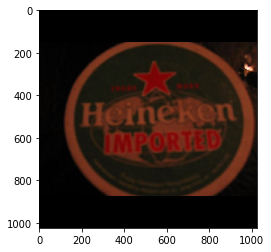

In [19]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

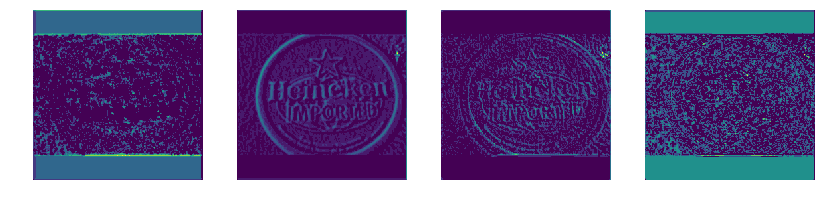

In [20]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)